# Load & process data

Add a cell on top of each notebook naming the input and output files. Describe what they are

In [2]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx 
import yaml
import matplotlib.pyplot as plt
import contextily as cx
from datetime import datetime
import json
from src import evaluation_functions as ef
from src import matching_functions as mf
from src import simplification_functions_new as sf

**Load settings for analysis:**

In [3]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    use_custom_filter = parsed_yaml_file['use_custom_filter']
    custom_filter = parsed_yaml_file['custom_filter']
    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']
    osm_cycling_infrastructure_type = parsed_yaml_file['osm_cycling_infrastructure_type']
    osm_way_tags = parsed_yaml_file['osm_way_tags']

    reference_comparison = parsed_yaml_file['reference_comparison']
    reference_fp = parsed_yaml_file['reference_fp']
    reference_geometries = parsed_yaml_file['reference_geometries']
    cycling_bidirectional = parsed_yaml_file['bidirectional']
    ref_cycling_infrastructure_type = parsed_yaml_file['ref_cycling_infrastructure_type']
    reference_id_col = parsed_yaml_file['reference_id_col']

    grid_cell_size = parsed_yaml_file['grid_cell_size']

    
print('Settings loaded!')

ef.check_settings_validity(study_area, study_area_poly_fp, study_crs, use_custom_filter, custom_filter, reference_comparison,
    reference_fp, reference_geometries, cycling_bidirectional, grid_cell_size)


Settings loaded!


## Load data defining study area

The size of the study area is 181.38 square kilometers


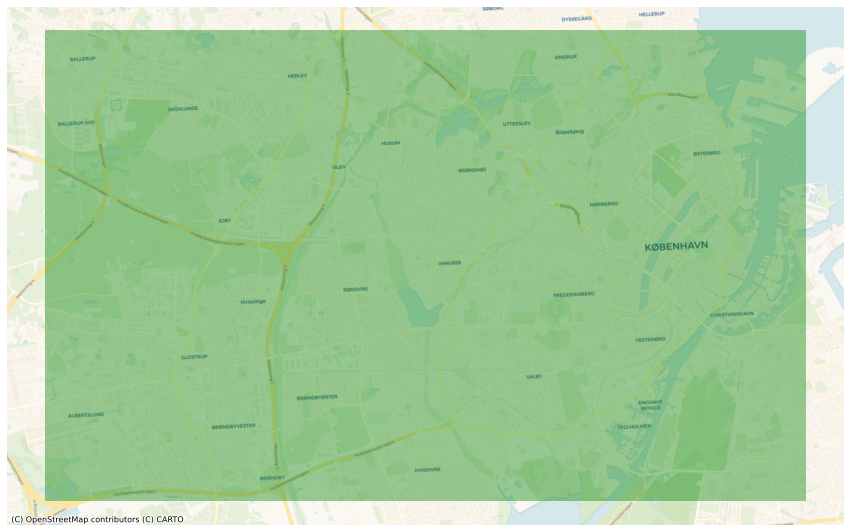

In [4]:
# Read polygon for study area
study_area_poly = gpd.read_file(study_area_poly_fp)

if study_area_poly.crs == None:
    print('Please assign a crs to the study area polygon!')

if study_area_poly.crs != study_crs:
    study_area_poly = study_area_poly.to_crs(study_crs)

assert study_area_poly.crs == study_crs

area = study_area_poly.area.values[0]
print(f'The size of the study area is {area / 1000000:.2f} square kilometers')

fig, ax = plt.subplots(1, figsize=(15,15))

study_area_poly.plot(ax=ax, color='green', alpha=0.4)

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager)

### Create grid to be used in the analysis

/opt/miniconda3/envs/cdq/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


The grid contains 770 cells


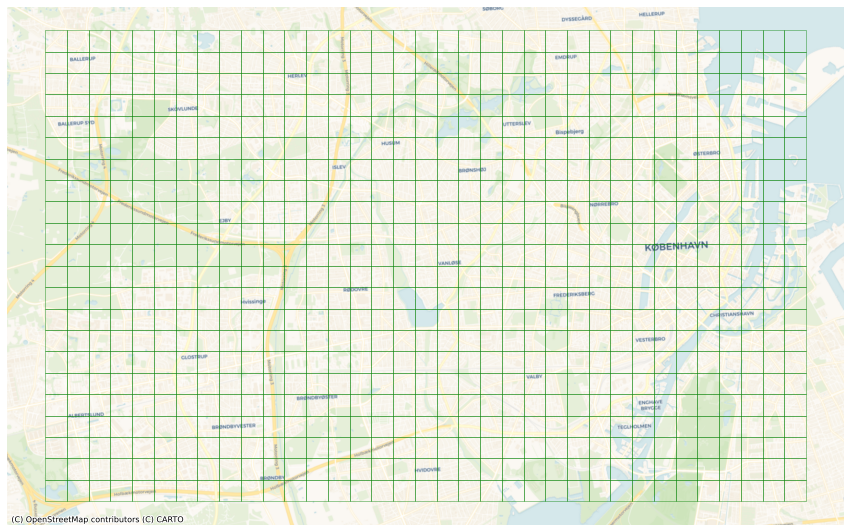

In [5]:
grid = ef.create_grid_geometry(study_area_poly, grid_cell_size)

grid['grid_id'] = grid.index

grid.to_file(f'../data/grid_{study_area}.gpkg')

fig, ax = plt.subplots(1, figsize=(15,15))

print(f'The grid contains {len(grid)} cells')

grid.plot(ax=ax, facecolor='none', edgecolor='green', alpha=0.4)

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager)

## Load OSM data

In this step we:
- Download data from OpenStreetMap using OSMnx
- Project the data to the chosen CRS
- Create a subnetwork consisting only of cycling infrastructure is created
- Classify all edges in the cycling network based on whether they are protected or unprotected cycling infrastructure, how they have been digitised, and whether they allow for bidirectional travel or not
- Simplify the network *(to read more about the modified OSMnx simplification (Boeing, 2017) used here, we refer to this [Github repository](https://github.com/anerv/NERDS_osmnx) which contains both the simplification functions, explanation of the logic and a demonstration)*

Depending on the size of your study area, getting data through OSMnx can take a little while.

In [147]:

ox.utils.config(use_cache=False, 
    useful_tags_way = osm_way_tags)

graph_osm = ox.graph_from_polygon(study_area_poly.to_crs('EPSG:4326').loc[0, 'geometry'], network_type='bike', simplify=False, retain_all=True, truncate_by_edge=False, clean_periphery=True)

print('Data retrieved!')

# Project graph to chosen crs
graph_osm = ox.project_graph(graph_osm, to_crs=study_crs)

# Get osm_edges and osm_nodes
osm_nodes, osm_edges = ox.graph_to_gdfs(graph_osm)

# Clean up column names (removing ':' and upper case letters)
osm_edges = mf.clean_col_names(osm_edges)
osm_nodes = mf.clean_col_names(osm_nodes)

# Add attribute on whether cycling infra exist or not (to be used by e.g. simplification function)
osm_edges['cycling_infrastructure'] = 'no'

for q in cycling_infrastructure_queries.values():

    try:
        ox_filtered = osm_edges.query(q)

    except Exception:
        print('Exception occured when quering with:', q)

    osm_edges.loc[ox_filtered.index, 'cycling_infrastructure'] = 'yes'

osm_edges.cycling_infrastructure.value_counts()

cycling_edges = osm_edges.loc[osm_edges.cycling_infrastructure == 'yes'].copy()

# If the new subset of edges contains edges with 1 but no corresponding edge with 0 as a key, fix this
cycling_edges = ef.fix_key_index(cycling_edges)

# Define whether cycling infrastructure is in both or one direction and whether it is one- or bidirectional
cycling_edges = ef.simplify_cycling_tags(cycling_edges)

# Classify edges as protected or unprotected
cycling_edges = ef.define_protected_unprotected(cycling_edges, osm_cycling_infrastructure_type)

cycling_graph, cycling_nodes = ef.create_cycling_network(cycling_edges, osm_nodes, graph_osm, return_nodes=True)
print('Created network only with cycling infrastructure!')

# Simplify cycling network
cycling_graph_simplified = sf.momepy_simplify_graph(cycling_graph, attributes=['cycling_infrastructure','cycling_bidirectional','cycling_geometries','protected'])

# Get undirected network representation
cycling_graph_simplified = ox.get_undirected(cycling_graph_simplified)
cycling_graph = ox.get_undirected(cycling_graph)

cycling_nodes_simplified, cycling_edges_simplified = ox.graph_to_gdfs(cycling_graph_simplified, nodes=True)

# TODO: Save length to both graphs 

# Measure the length of cycling infrastructure (!=from length of edges)
cycling_edges_simplified['length'] = cycling_edges_simplified.geometry.length
cycling_edges_simplified['infrastructure_length'] = cycling_edges_simplified.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)

# Creating coulumns with unique feature id (required by some functions)
cycling_edges['edge_id'] = cycling_edges.reset_index().index
cycling_edges_simplified['edge_id'] = cycling_edges_simplified.reset_index().index

osm_id_dict = cycling_edges['edge_id'].to_dict()
nx.set_edge_attributes(cycling_graph, osm_id_dict, 'edge_id')

osm_id_dict_s = cycling_edges_simplified['edge_id'].to_dict()
nx.set_edge_attributes(cycling_graph_simplified, osm_id_dict_s, 'edge_id')

# TODO: Create and save node id for both
cycling_nodes['node_id'] = cycling_nodes.reset_index().index
cycling_nodes_simplified['node_id'] = cycling_nodes_simplified.reset_index().index

osm_id_dict = cycling_nodes['node_id'].to_dict()
nx.set_node_attributes(cycling_graph, osm_id_dict, 'node_id')

osm_id_dict_s = cycling_nodes_simplified['node_id'].to_dict()
nx.set_node_attributes(cycling_graph_simplified, osm_id_dict_s, 'node_id')

# Saving data to graphs
osm_l_dict = osm_edges['length'].to_dict()
nx.set_edge_attributes(cycling_graph, osm_l_dict, 'length')

osm_l_dict_s = cycling_edges_simplified['length'].to_dict()
nx.set_edge_attributes(cycling_graph_simplified, osm_l_dict_s, 'length')

osm_il_dict = cycling_edges_simplified['infrastructure_length'].to_dict()
nx.set_edge_attributes(cycling_graph_simplified, osm_il_dict, 'infrastructure_length')

# Overview of data from OSM
graph_area = ef.get_graph_area(cycling_nodes, study_area_poly, study_crs)
print(f'The graph covers an area of {graph_area/ 1000000:.2f} square kilometers')

print(f'The length of the OSM network with cycling infrastructure is {cycling_edges_simplified.infrastructure_length.sum()/1000 :.2f} kilometers')

Data retrieved!
No edge with same nodes and key==0
No edge with same nodes and key==0
Bidirectional Value Counts: 
 False    32149
True     17463
Name: cycling_bidirectional, dtype: int64
Geometry Type Value Counts: 
 centerline         25464
true_geometries    24148
Name: cycling_geometries, dtype: int64
Protected Value Counts: 
 protected      45222
unprotected     3766
mixed            624
Name: protected, dtype: int64
Created network only with cycling infrastructure!
The graph covers an area of 179.70 square kilometers
The length of the OSM network with cycling infrastructure is 1063.98 kilometers


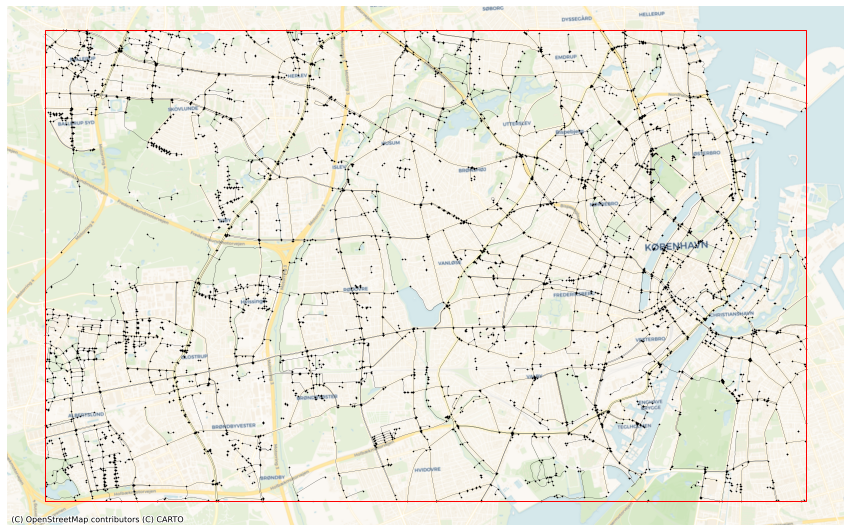

In [148]:
# Plot network
fig, ax = plt.subplots(1, figsize=(15,15))

cycling_edges_simplified.plot(ax=ax, color='black', linewidth=0.2)
cycling_nodes_simplified.plot(ax=ax, color='black', markersize=0.3)

study_area_poly.plot(ax=ax, edgecolor='red', facecolor='None', linewidth=1)

cx.add_basemap(
    ax=ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager
)
ax.set_axis_off()

In [9]:
# Save data
ox.save_graphml(cycling_graph_un, f'../data/osm_{study_area}.graphml')
ox.save_graphml(cycling_graph_simplified, f'../data/osm_{study_area}_simple.graphml')
print('OSM networks saved!')

data_load_dict = {}

# Save time for when OSM data was loaded
current_time = datetime.now().strftime('%m/%d/%Y, %H:%M:%S')
data_load_dict['data_retrieved_at'] = current_time

# TODO
# Save results of simplifying network
data_load_dict['nodes_removed_during_simplification'] = len(cycling_nodes) - len(cycling_nodes_simplified)
data_load_dict['edges_removed_during_simplification'] = len(cycling_edges) - len(cycling_edges_simplified)

with open(f'../data/osm_meta_{study_area}.json', 'w') as outfile:
    json.dump(data_load_dict, outfile)

OSM networks saved!


## Load reference data

In this step we:
- Create a network from the reference data
- Project it to the chosen CRS
- Clip the data to the polygon defning the study area
- Measure the infrastructure length the edges based on the geometry type and whether they allow for bidirectional travel or not
- Simplify the network

The reference data covers an area of 169.76 square kilometers
Protected Value Counts: 
 protected      8438
unprotected    2130
Name: protected, dtype: int64
The length of the reference network is 623.52 kilometers
Reference networks saved!


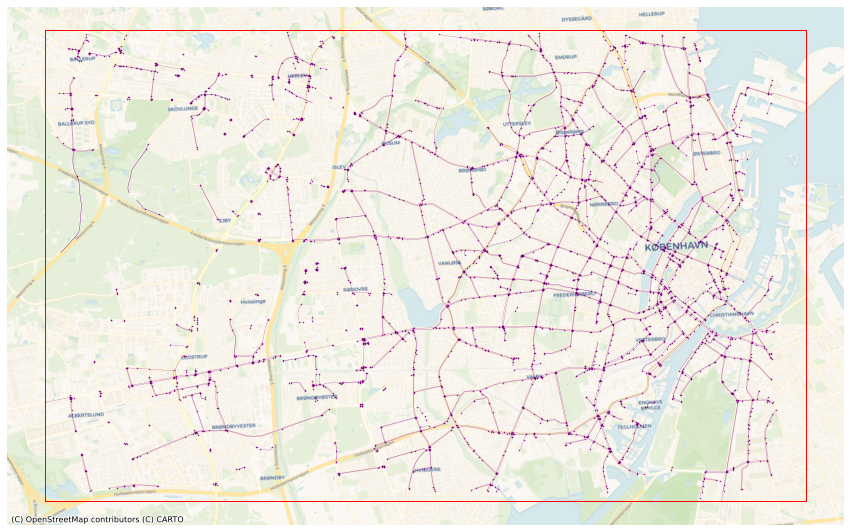

In [39]:
if reference_comparison:

    # Read reference data
    ref_data = gpd.read_file(reference_fp)

    # Create column with id called 'osmid'
    ref_data['osmid'] = ref_data[reference_id_col]

    # Reproject
    if ref_data.crs == None:
        print('Please assign a crs to the study area polygon!')

    if ref_data.crs != study_crs:
        ref_data = ref_data.to_crs(study_crs)

    assert ref_data.crs == study_crs

    # Clip reference data to study area poly
    ref_data = ref_data.clip(study_area_poly)

    # Convert to osmnx graph object
    graph_ref = mf.create_osmnx_graph(ref_data)

    ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)

    # Overview of data
    graph_area = ef.get_graph_area(ref_nodes, study_area_poly, study_crs)
    print(f'The reference data covers an area of {graph_area / 1000000:.2f} square kilometers')

    # Classify edges as protected or unprotected
    ref_edges = ef.define_protected_unprotected(ref_edges, ref_cycling_infrastructure_type)

    # Recreate graph with updated data
    graph_ref = mf.create_osmnx_graph(ref_edges)

    # Simplify - the graph is simplified as much as possible, but without combining edges with conflicting values of cycling infrastructure types
    graph_ref_simple = sf.momepy_simplify_graph(graph_ref, attributes=['vejklasse','protected'])

    graph_ref = ox.get_undirected(graph_ref)
    ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)
    graph_ref_simple = ox.get_undirected(graph_ref_simple)

    ref_nodes_simplified, ref_edges_simplified = ox.graph_to_gdfs(graph_ref_simple)

    ref_edges['length'] = ref_edges.geometry.length
    ref_edges_simplified['length'] = ref_edges_simplified.geometry.length

    # Measure the length of cycling infrastructure (!=from length of edges)
    if reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
        ref_edges_simplified['infrastructure_length'] = ref_edges_simplified.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=x.reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

    elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
        ref_edges_simplified['infrastructure_length'] = ref_edges_simplified.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

        
    elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
        ref_edges_simplified['infrastructure_length'] = ref_edges_simplified.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

       
    elif reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
        ref_edges_simplified['infrastructure_length'] = ref_edges_simplified.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=x.reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)
        
    else:
        print(f'Invalid data types for the variables reference_geometetries and/or cycling_bidirectional!')
    
    print(f'The length of the reference network is {ref_edges_simplified.infrastructure_length.sum()/1000 :.2f} kilometers')


    # Creating coulumns with unique feature id (required by some functions)
    ref_edges['edge_id'] = ref_edges.reset_index().index
    ref_edges_simplified['edge_id'] = ref_edges_simplified.reset_index().index

    ref_id_dict = ref_edges['edge_id'].to_dict()
    nx.set_edge_attributes(graph_ref, ref_id_dict, 'edge_id')

    ref_id_dict_s = ref_edges_simplified['edge_id'].to_dict()
    nx.set_edge_attributes(graph_ref_simple, ref_id_dict_s, 'edge_id')

    ref_nodes['node_id'] = ref_nodes.reset_index().index
    ref_nodes_simplified['node_id'] = ref_nodes_simplified.reset_index().index

    ref_id_dict = ref_nodes['node_id'].to_dict()
    nx.set_node_attributes(graph_ref, ref_id_dict, 'node_id')

    ref_id_dict_s = ref_nodes_simplified['node_id'].to_dict()
    nx.set_node_attributes(graph_ref_simple, ref_id_dict_s, 'node_id')

    # Saving data to graphs
    ref_l_dict = ref_edges['length'].to_dict()
    nx.set_edge_attributes(graph_ref, ref_l_dict, 'length')

    ref_l_dict_s = ref_edges_simplified['length'].to_dict()
    nx.set_edge_attributes(graph_ref_simple, ref_l_dict_s, 'length')

    ref_il_dict = ref_edges_simplified['infrastructure_length'].to_dict()
    nx.set_edge_attributes(graph_ref_simple, ref_il_dict, 'infrastructure_length')

    # Plot network
    fig, ax = plt.subplots(1, figsize=(15,15))

    ref_edges_simplified.plot(ax=ax, color='purple', linewidth=0.2)
    ref_nodes_simplified.plot(ax=ax, color='purple', markersize=0.2)

    study_area_poly.plot(ax=ax, edgecolor='red', facecolor='None', linewidth=1)

    ax.set_axis_off()

    cx.add_basemap(
        ax, 
        crs=study_area_poly.crs, 
        source=cx.providers.CartoDB.Voyager
    )

    # Save data
    ox.save_graphml(graph_ref, f'../data/ref_{study_area}.graphml')

    ox.save_graphml(graph_ref_simple, f'../data/ref_{study_area}_simple.graphml')

    print('Reference networks saved!')

    data_load_dict = {}

    # Save results of simplifying network
    data_load_dict['nodes_removed_during_simplification'] = len(ref_nodes) - len(ref_nodes_simplified)
    data_load_dict['edges_removed_during_simplification'] = len(ref_edges) - len(ref_edges_simplified)

    with open(f'../data/reference_meta_{study_area}.json', 'w') as outfile:
        json.dump(data_load_dict, outfile)

else:
    print('The analysis will not make use of a reference data set. Please update config settings if an extrinsic analysis of OSM data quality should be performed.')

In [40]:
# Check that all edges and nodes have id and length and that simplified edges have infrastructure length

# Load simplified and non-simplified graphs
ref_graph_t = ox.load_graphml(f'../data/ref_{study_area}.graphml')
ref_simplified_graph_t = ox.load_graphml(f'../data/ref_{study_area}_simple.graphml')

# Convert to nodes and ref_edges
ref_nodes_t, ref_edges_t = ox.graph_to_gdfs(ref_graph_t)
ref_simplified_nodes_t, ref_simplified_edges_t = ox.graph_to_gdfs(ref_simplified_graph_t)

In [35]:
ref_graph_t

In [11]:
ref_nodes.columns

Index(['nodeID', 'x', 'y', 'node_id', 'geometry'], dtype='object')

In [41]:
assert len(ref_nodes) == len(ref_nodes.node_id.unique())

In [42]:
assert len(ref_edges) == len(ref_edges.edge_id.unique())

In [43]:
assert len(ref_edges_t) == len(ref_edges_t.edge_id.unique())

In [44]:
assert len(ref_simplified_edges_t) == len(ref_simplified_edges_t.edge_id.unique())

In [16]:
len(ref_edges)

10568

In [48]:
ref_simplified_edges_t

fot_id mob_id  \
u     v     key                                                             
0     1     0                                           1087309035      0   
      3     0                             [1087377473, 1087291957]      0   
3     10    0                             [1087282540, 1087282750]      0   
5     46    0    [1087374532, 1087365612, 1087371117, 108737457...      0   
10    13    0                             [1087296362, 1087292062]      0   
...                                                            ...    ...   
10003 10004 0                                           1081254945      0   
10004 10005 0                                           1081223106      0   
10008 10010 0                             [1081230893, 1081219550]      0   
10011 10012 0                                           1081233972      0   
10013 10014 0                                           1104753639      0   

                feat_kode       feat_type    featstatus geomstatus startknude  \
u     v     key                                                                 
0     1     0        9963  Vejmidte_brudt  Taget i brug    Endelig       -999   
      3     0        9963  Vejmidte_brudt  Taget i brug    Endelig       -999   
3     10    0        9963  Vejmidte_brudt  Taget i brug    Endelig       -999   
5     46    0        9963  Vejmidte_brudt  Taget i brug    Endelig       -999   
10    13    0        9963  Vejmidte_brudt  Taget i brug    Endelig       -999   
...                   ...             ...           ...        ...        ...   
10003 10004 0        9963  Vejmidte_brudt  Taget i brug    Endelig       -999   
10004 10005 0        9963  Vejmidte_brudt  Taget i brug    Endelig       -999   
10008 10010 0        9963  Vejmidte_brudt  Taget i brug    Endelig       -999   
10011 10012 0        9963  Vejmidte_brudt  Taget i brug    Endelig       -999   
10013 10014 0        9963  Vejmidte_brudt  Taget i brug    Endelig       -999   

                slutknude        niveau overflade  ...  \
u     v     key                                    ...   
0     1     0        -999  Ikke tildelt  Befæstet  ...   
      3     0        -999  Ikke tildelt  Befæstet  ...   
3     10    0        -999  Ikke tildelt  Befæstet  ...   
5     46    0        -999  Ikke tildelt  Befæstet  ...   
10    13    0        -999  Ikke tildelt  Befæstet  ...   
...                   ...           ...       ...  ...   
10003 10004 0        -999  Ikke tildelt  Befæstet  ...   
10004 10005 0        -999  Ikke tildelt  Befæstet  ...   
10008 10010 0        -999  Ikke tildelt  Befæstet  ...   
10011 10012 0        -999  Ikke tildelt  Befæstet  ...   
10013 10014 0        -999  Ikke tildelt  Befæstet  ...   

                                                             osmid  \
u     v     key                                                      
0     1     0                                           1087309035   
      3     0                             [1087377473, 1087291957]   
3     10    0                             [1087282540, 1087282750]   
5     46    0    [1087374532, 1087365612, 1087371117, 108737457...   
10    13    0                             [1087296362, 1087292062]   
...                                                            ...   
10003 10004 0                                           1081254945   
10004 10005 0                                           1081223106   
10008 10010 0                             [1081230893, 1081219550]   
10011 10012 0                                           1081233972   
10013 10014 0                                           1104753639   

                                                            mm_len  \
u     v     key                                                      
0     1     0                                   144.11639481805724   
      3     0              [187.27279948196926, 45.88363254535646]   
3     10    0             [60.417984429017494, 135.3950934

In [22]:
ref_edges

fot_id  mob_id  feat_kode       feat_type    featstatus  \
u     v     key                                                                
00000 00001 0    1087309035       0       9963  Vejmidte_brudt  Taget i brug   
      00004 0    1087291957       0       9963  Vejmidte_brudt  Taget i brug   
00004 00033 0    1087377473       0       9963  Vejmidte_brudt  Taget i brug   
00002 00003 0    1087371117       0       9963  Vejmidte_brudt  Taget i brug   
00005 00002 0    1087378327       0       9963  Vejmidte_brudt  Taget i brug   
...                     ...     ...        ...             ...           ...   
10008 10009 0    1081219550       0       9963  Vejmidte_brudt  Taget i brug   
10009 10011 0    1081230893       0       9963  Vejmidte_brudt  Taget i brug   
10010 10005 0    1081219604       0       9963  Vejmidte_brudt  Taget i brug   
      10014 0    1081233972       0       9963  Vejmidte_brudt  Taget i brug   
10012 10013 0    1104753639       0       9963  Vejmidte_brudt  Taget i brug   

                geomstatus  startknude  slutknude        niveau overflade  \
u     v     key                                                             
00000 00001 0      Endelig        -999       -999  Ikke tildelt  Befæstet   
      00004 0      Endelig        -999       -999  Ikke tildelt  Befæstet   
00004 00033 0      Endelig        -999       -999  Ikke tildelt  Befæstet   
00002 00003 0      Endelig        -999       -999  Ikke tildelt  Befæstet   
00005 00002 0      Endelig        -999       -999  Ikke tildelt  Befæstet   
...                    ...         ...        ...           ...       ...   
10008 10009 0      Endelig        -999       -999  Ikke tildelt  Befæstet   
10009 10011 0      Endelig        -999       -999  Ikke tildelt  Befæstet   
10010 10005 0      Endelig        -999       -999  Ikke tildelt  Befæstet   
      10014 0      Endelig        -999       -999  Ikke tildelt  Befæstet   
10012 10013 0      Endelig        -999       -999  Ikke tildelt  Befæstet   

                 ...      vej_mynd vej_type  \
u     v     key  ...                          
00000 00001 0    ...  Ikke tildelt      Sti   
      00004 0    ...  Ikke tildelt      Sti   
00004 00033 0    ...  Ikke tildelt      Sti   
00002 00003 0    ...  Ikke tildelt      Sti   
00005 00002 0    ...  Ikke tildelt      Sti   
...              ...           ...      ...   
10008 10009 0    ...  Ikke tildelt      Sti   
10009 10011 0    ...  Ikke tildelt      Sti   
10010 10005 0    ...  Ikke tildelt      Sti   
      10014 0    ...  Ikke tildelt      Sti   
10012 10013 0    ...  Ikke tildelt      Sti   

                                                          geometry  \
u     v     key                                                      
00000 00001 0    LINESTRING (722807.420 6171602.090, 722808.290...   
      00004 0    LINESTRING (722807.420 6171602.090, 722806.600...   
00004 00033 0    LINESTRING (722767.470 6171785.050, 722766.740...   
00002 00003 0    LINESTRING (722807.970 6171659.700, 722808.520...   
00005 00002 0    LINESTRING (722790.420 6171740.350, 722791.360...   
...                                                            ...   
10008 10009 0    LINESTRING (711145.130 6181617.080, 711143.210...   
10009 10011 0    LINESTRING (711140.170 6181629.070, 711137.410...   
10010 10005 0    LINESTRING (711106.700 6181689.540, 711107.130...   
      10014 0    LINESTRING (711106.700 6181689.540, 711108.290...   
10012 10013 0    LINESTRING (711968.120 6181661.070, 711982.400...   

                      osmid      mm_len node_start node_end      length  \
u     v     key                                                           
00000 00001 0    1087309035  144.116395          0        1  144.116395   
      00004 0    1087291957  187.272799          0        4  187.272799   
00004 00033 0    1087377473   45.883633          4       33   45.883633   
00002 00003 0    1087371117  106.739708          2        3  106.739708   
00005

In [38]:
ref_nodes

,nodeID,x,y,geometry,node_id
osmid,,,,,
00000,0,722807.42,6171602.09,POINT (722807.420 6171602.090),0
00001,1,722839.01,6171461.50,POINT (722839.010 6171461.500),1
00004,4,722767.47,6171785.05,POINT (722767.470 6171785.050),2
00002,2,722807.97,6171659.70,POINT (722807.970 6171659.700),3
00003,3,722830.79,6171555.43,POINT (722830.790 6171555.430),4
...,...,...,...,...,...
10011,10011,711137.41,6181636.47,POINT (711137.410 6181636.470),10010
10010,10010,711106.70,6181689.54,POINT (711106.700 6181689.540),10011
10014,10014,711113.47,6181759.63,POINT (711113.470 6181759.630),10012


In [36]:
test = ref_edges['edge_id'].to_dict()
test

{('00000', '00001', 0): 0,
 ('00000', '00004', 0): 1,
 ('00004', '00033', 0): 2,
 ('00002', '00003', 0): 3,
 ('00005', '00002', 0): 4,
 ('00006', '00005', 0): 5,
 ('00007', '00006', 0): 6,
 ('00008', '00007', 0): 7,
 ('00009', '00010', 0): 8,
 ('00009', '00035', 0): 9,
 ('00010', '00013', 0): 10,
 ('00035', '00033', 0): 11,
 ('00011', '00012', 0): 12,
 ('00012', '00043', 0): 13,
 ('00043', '00048', 0): 14,
 ('00014', '00015', 0): 15,
 ('00014', '00019', 0): 16,
 ('00015', '00381', 0): 17,
 ('00019', '00022', 0): 18,
 ('00381', '00382', 0): 19,
 ('00016', '00017', 0): 20,
 ('00017', '00018', 0): 21,
 ('00018', '00020', 0): 22,
 ('00020', '00023', 0): 23,
 ('00020', '00026', 0): 24,
 ('00020', '00030', 0): 25,
 ('00022', '00032', 0): 26,
 ('00023', '00021', 0): 27,
 ('00030', '00053', 0): 28,
 ('00021', '00019', 0): 29,
 ('00032', '00045', 0): 30,
 ('00024', '00022', 0): 31,
 ('00025', '00024', 0): 32,
 ('00027', '00026', 0): 33,
 ('00027', '00025', 0): 34,
 ('00027', '00029', 0): 35,
 (

In [33]:
len(graph_ref.edges)

10568

In [37]:
ref_edges_t.index

MultiIndex([(    0,     1, 0),
            (    0,     2, 0),
            (    2,     3, 0),
            (    3,    12, 0),
            (    4,     5, 0),
            (    4,     6, 0),
            (    6,     7, 0),
            (    7,     8, 0),
            (    8,     9, 0),
            (    9,    45, 0),
            ...
            ( 9996,  9997, 0),
            ( 9997,  9998, 0),
            (10000, 10001, 0),
            (10006, 10007, 0),
            (10003, 10004, 0),
            (10004, 10005, 0),
            (10008, 10009, 0),
            (10009, 10010, 0),
            (10011, 10012, 0),
            (10013, 10014, 0)],
           names=['u', 'v', 'key'], length=10568)